In [ ]:
import re
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from itertools import chain
from collections import Counter

from reviews.config import root_dir

data_dir = root_dir / "data"
out_dir = root_dir / "output"
processed_data_dir = data_dir / "processed"
asum_output_dir = root_dir / "output" / "asum"

sns.set_style("white")

primary_color = "#ECE81A"  # 108de4ff"
secondary_color = "#C3C5C5"

# Models Comparison

In [ ]:
total_df = pd.DataFrame()
for n_topics in [10, 20, 30, 50]:
    for model in ["asum", "jst"]:
        for norm in ["raw", "stemming", "lemmatization"]:
            filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}.csv"

            if not filename.exists():
                continue

            df = pd.read_csv(filename)
            df["model"] = model
            df["normalization"] = norm

            total_df = pd.concat((df, total_df))

In [ ]:
total_df[total_df["model"] == "asum"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

In [ ]:
total_df[total_df["model"] == "jst"].groupby(["normalization", "n_topics"])[
    ["f1_macro", "f1_weighted", "f1_micro"]
].mean()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["model"] == "asum"],
    y="f1_macro",
    x="n_topics",
    hue="normalization",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.55, 0.65])

In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(
    total_df[total_df["normalization"] == "stemming"],
    y="f1_macro",
    x="n_topics",
    hue="model",
    ax=ax,
    err_style="bars",
    errorbar="sd",
)
ax.set_ylim([0.5, 0.65])

## Split by Commas and Conjunctions

In [141]:
total_df = pd.DataFrame()
n_topics = 50
model = "asum"
norm = "stemming"
for extra in ["", "_conj", "_comma"]:
    filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}{extra}.csv"

    if not filename.exists():
        continue

    df = pd.read_csv(filename)
    df["extra"] = "stemming" if extra == "" else extra.replace("_", "")

    total_df = pd.concat((df, total_df))
total_df

,Unnamed: 0,run,n_topics,f1_macro,f1_weighted,f1_micro,extra
0,0,0,50,0.609326,0.828343,0.792396,conj
1,1,1,50,0.620142,0.833890,0.799475,conj
2,2,2,50,0.604614,0.825127,0.787982,conj
3,3,3,50,0.622586,0.835038,0.800898,conj
4,4,4,50,0.614391,0.835558,0.803525,conj
5,5,5,50,0.603964,0.827490,0.792068,conj
6,6,6,50,0.614266,0.828762,0.792104,conj
7,7,7,50,0.614358,0.834184,0.801189,conj
8,8,8,50,0.624325,0.839479,0.808049,conj
9,9,9,50,0.618075,0.834241,0.800496,conj


<AxesSubplot: xlabel='f1_macro', ylabel='extra'>

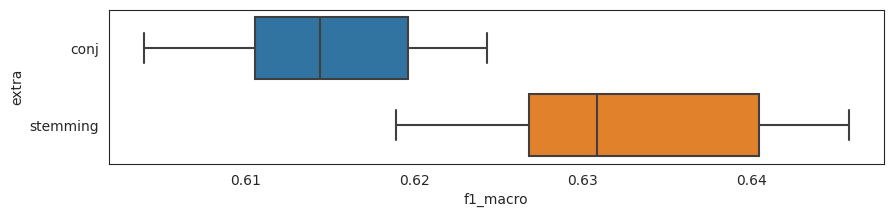

In [142]:
fig, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(total_df, y="extra", x="f1_macro", ax=ax)

In [143]:
total_df.groupby("extra")[["f1_macro", "f1_weighted"]].mean()

,f1_macro,f1_weighted
extra,,
conj,0.614605,0.832211
stemming,0.632539,0.844270


# ASPECT BASED SENTIMENT ANALYSIS (ASUM)

In [144]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary
EXTRA = ""  # _conj

In [145]:
n_runs = 10
n_topics = 50
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

# Read Reviews Data

In [146]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}{EXTRA}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.54%
Empty Reviews: 0.05%


In [147]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

## PI = documents x sentiment

In [148]:
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

## PHI = vocabulary x senti aspects

In [149]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)

## THETA = documents x senti aspects


In [150]:
def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

In [151]:
# reviews with equal probabilities for each topic
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  162


In [152]:
(f_theta_df > T).sum(axis=1).describe()

count    28821.000000
mean         1.619722
std          0.913355
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [153]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0               [S0-T25, S0-T39]
1        [S0-T3, S0-T17, S1-T24]
2               [S0-T44, S1-T11]
3                       [S0-T41]
4                       [S1-T26]
                  ...           
28978            [S0-T2, S0-T19]
28979            [S1-T3, S1-T29]
28980                    [S0-T8]
28981                   [S1-T36]
28982                   [S0-T23]
Length: 28983, dtype: object

In [154]:
one_token_idx = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 2)
topics[one_token_idx]

20       [S1-T36, S1-T45]
37               [S1-T36]
54               [S0-T20]
70               [S0-T37]
82               [S0-T21]
               ...       
28938            [S0-T46]
28945            [S1-T36]
28968      [S0-T9, S1-T7]
28975            [S1-T11]
28976            [S0-T36]
Length: 1724, dtype: object

In [155]:
reviews_df.loc[20]

asin                                                      B00FPIMJEW
overall                                                            4
reviewerID                                            A2G5UWIC85104M
summary                                  It does what it's made for.
text                                         It works.  No problems.
timestamp                                        2015-10-04 00:00:00
vote                                                               0
brand                                                        inateck
category                                              I/O Port Cards
description        Due to frequently updated drivers, please down...
imageURLHighRes    https://images-na.ssl-images-amazon.com/images...
price                                                           2.54
title              Inateck PCI-E to USB 3.0 (5 Ports) PCI Express...
tokens                                       [[work], [not_problem]]
Name: 20, dtype: object

In [156]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
# reviews_df.to_json(asum_output_dir / "topics.json", orient="records")
#reviews_df["topics"]

## ProbWords

In [157]:
prob_words_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")
columns = prob_words_df.columns.map(map_topic_sentiment)

In [158]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    if match is None:
        print(text)
    word, weight = match.groups()
    return word, float(weight)


def plot_prob_words():
    n_top_words = 20
    total_df = pd.DataFrame()

    fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(50, 50))
    for idx, item in enumerate(columns):
        if item is None:
            continue

        ax = axes[
            int(int(item["topic"] / 10) * 2 + item["sentiment"]),
            int(item["topic"] % 10),
        ]
        words = prob_words_df[item["colname"]][:n_top_words]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        w = weights.copy()
        w["colname"] = item["colname"]
        total_df = pd.concat((total_df, w))

        ax.barh(weights["names"], weights["weights"], height=0.5)
        ax.set_title(item["colname"])

        ax.set_xlabel(f"Topic {item['topic'] + 1}")
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

    fig.tight_layout()

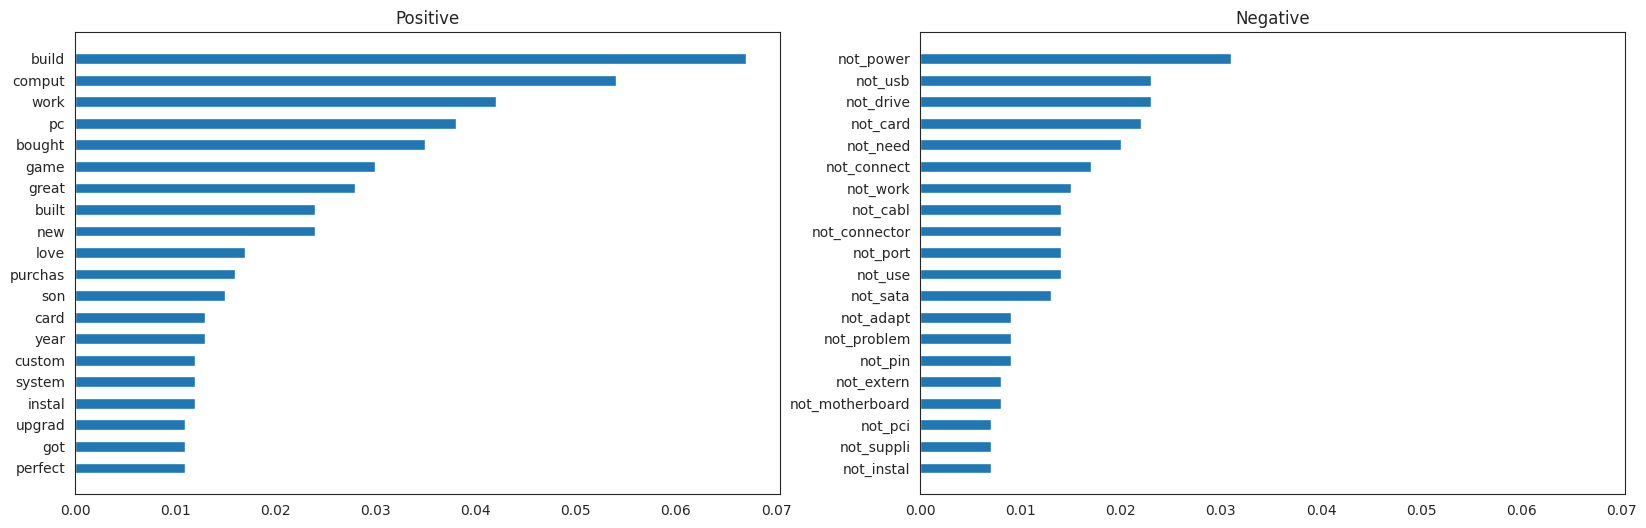

In [159]:
def show_topic(topic, n=20):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    axes = axes.flatten()

    for s in range(2):
        words = prob_words_df[f"S{s}-{topic}"][:n]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        axes[s].barh(weights["names"], weights["weights"], height=0.5)
        axes[s].set_title("Positive" if s == 0 else "Negative")


def print_examples(topic, k=5, show_tokens=True):
    ddf = reviews_df.copy()
    ddf["topics"] = ddf["topics"].apply(lambda x: set([y["colname"] for y in x]))

    pos_examples = pd.Series(
        [row["tokens" if show_tokens else "text"] for i, row in ddf.iterrows() if f"S0-{topic}" in row["topics"]]
    ).sample(k)
    neg_examples = pd.Series(
        [row["tokens" if show_tokens else "text"] for i, row in ddf.iterrows() if f"S1-{topic}" in row["topics"]]
    ).sample(k)

    print(
        "Positive ---------------------------------------------------------------------------------\n"
    )
    [print(">----------\n", ex) for ex in pos_examples]

    print(
        "\nNegative ---------------------------------------------------------------------------------"
    )
    [print(">----------\n", ex) for ex in neg_examples]


topic_mapping = {
    "T0": "PSU",
    "T1": "time",
    "T2": "delivery",
    "T3": "cooling system",
    "T4": "cooling system",
    "T5": "performance",
    "T6": "memory",
    "T7": "satisfaction",
    "T8": "PSU",
    "T9": "price",
    "T10": "PC",
    "T11": "graphics",
    "T12": "performance",
    "T13": "installation",
    "T14": "satisfaction",
    "T15": "cooling system",
    "T16": "temperature",
    "T17": "overclocking",
    "T18": "satisfaction",
    "T19": "installation",
    "T20": "satisfaction",
    "T21": "satisfaction",
    "T22": "sound",
    "T23": "PSU",
    "T24": "installation",
    "T25": "quality",
    "T26": "quality",
    "T27": "delivery",
    "T28": "aesthetic",
    "T29": "performance",
    "T30": "installation",
    "T31": "pc build",
    "T32": "installation",
    "T33": "CPU",
    "T34": "upgrade",
    "T35": "satisfaction",
    "T36": "motherboard",
    "T37": "satisfaction",
    "T38": "cooling system",
    "T39": "installation",
    "T40": "performance", # gaming
    "T41": "motherboard",
    "T42": "cooling system",
    "T43": "optical disc",
    "T44": "memory",
    "T45": "thermal paste",
    "T46": "satisfaction",
    "T47": "satisfaction",
    "T48": "motherboard",
    "T49": "memory"
}

topic = "T31"
show_topic(topic, n=20)

In [160]:
print_examples(topic, show_tokens=True)

Positive ---------------------------------------------------------------------------------

>----------
 [['bought', 'custom', 'build', 'work', 'fine']]
>----------
 [['build', 'comput', 'mom'], ['matx', 'motherboard', 'tower'], ['measur', 'cpu', 'motherboard', 'tower', 'cooler', 'fit', 'perfect'], ['cooler', 'fan', 'pin', 'connector']]
>----------
 [['power', 'suppli', 'loud', 'sop', 'work', 'month'], ['thank', 'amazon', 'stood', 'purchas']]
>----------
 [['final', 'usb', 'pci', 'card', 'sata', 'power', 'suppli'], ['work', 'window']]
>----------
 [['love'], ['recent', 'decid', 'pc', 'game'], ['game', 'miss', 'left', 'graphic', 'demand', 'not_heavi'], ['right', 'play', 'dark', 'soul', 'run', 'like', 'charm'], ['not_sure', 'not_run', 'not_new', 'not_game', 'not_time', 'not_buy', 'not_wishlist', 'not_save', 'not_line', 'not_card'], ['game', 'limit', 'budget', 'card', 'serv', 'purpos'], ['rememb', 'check', 'run', 'game', 'want', 'buy']]

Negative ------------------------------------------

In [161]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
words_probs = phi_df.set_index("Unnamed: 0")
tot_probs = words_probs.sum(axis=1)

pos_t = [f"S0-T{t}" for t in range(n_topics)]
pos_probs = words_probs[pos_t]
pos_max_probs = pos_probs.sum(axis=1).max()

neg_t = [f"S1-T{t}" for t in range(n_topics)]
neg_probs = words_probs[neg_t]
neg_max_probs = neg_probs.sum(axis=1).max()

print(pos_max_probs, neg_max_probs)


#pos_probs.sum(axis=1) / pos_max_probs
probs = pd.DataFrame({
    "pos": pos_probs.sum(axis=1) / tot_probs,
    "neg": neg_probs.sum(axis=1) / tot_probs
})


1.9340590061931133 1.1813846392504488


## Sentiment

In [ ]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

In [249]:
corsair_df = reviews_df[reviews_df["brand"] == "corsair"]

from_year = '2018'
to_year = '2018'
if int(from_year) >= int(to_year):
    to = int(from_year)
else:
    to = int(to_year)

to = pd.Timestamp(year=to, month=12, day=31)

year_mask = (corsair_df["timestamp"] >= from_year) & (corsair_df["timestamp"] <= to)
corsair_df_2018 = corsair_df[year_mask].copy()

fig = px.pie(
    corsair_df_2018["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
    width=400,
    height=400,
)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig.write_image("../output/sentiment.png")
fig

### Sentiment Over Time

In [240]:
from dashboard.utils import default_layout

corsair_df = reviews_df[reviews_df["brand"] == "corsair"]

period = "Y"
corsair_df["period"] = corsair_df["timestamp"].dt.to_period(period)
corsair_df["period"] = corsair_df["period"].dt.to_timestamp()

sentiments_count = corsair_df.groupby("period")["sentiment"].value_counts()
sentiments_df = pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
total_reviews = sentiments_df.groupby("period")["count"].sum().reset_index()

sentiments_df = pd.merge(sentiments_df, total_reviews, on="period")
sentiments_df["percentage"] = sentiments_df["count_x"] / sentiments_df["count_y"] * 100

fig = px.bar(
    sentiments_df,
    x="period",
    y="percentage",
    color="sentiment",
    #markers=True,
    category_orders={"sentiment": ["positive", "negative"]},
    color_discrete_sequence=["#27d957", "#f54242"],
    width=1000,
    height=400,
)

fig.update_layout(default_layout)
fig.update_layout(legend_orientation="v", margin=dict(t=40))
fig.update_yaxes(title_text="% Reviews", ticksuffix="%")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

fig.write_image("../output/sentiment_over_time.png")
fig

/tmp/ipykernel_19128/2452899567.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_19128/2452899567.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Sentiment Categories

In [263]:
sentiments_count = corsair_df_2018.groupby("category")["sentiment"].value_counts()
sentiments_count_perc = sentiments_count / sentiments_count.groupby("category").sum() * 100
sentiments_df_perc = pd.DataFrame(sentiments_count_perc).rename(columns={"sentiment": "percentage"}).reset_index()
sentiments_df_perc.sort_values(by="percentage", inplace=True)
print(sentiments_df_perc)

category_orders = {"sentiment": ["positive", "negative"]}

fig = px.bar(
    sentiments_df_perc,
    x="percentage",
    y="category",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    barmode="relative",
    category_orders=category_orders,
    width=800,
    height=400,
)

fig.update_xaxes(ticksuffix="%")
fig.update_layout(default_layout)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), showlegend=False)
fig.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)
fig.write_image("../output/sentiment_categories.png")
fig

                   category sentiment  percentage
7  TV Tuner & Capture Cards  negative   14.285714
3                    Memory  negative   30.136986
5            Power Supplies  negative   32.258065
1            Fans & Cooling  negative   37.681159
0            Fans & Cooling  positive   62.318841
4            Power Supplies  positive   67.741935
2                    Memory  positive   69.863014
6  TV Tuner & Capture Cards  positive   85.714286


## Topics

In [164]:
count = Counter()
for x in reviews_df["topics"].values:
    topics = set([topic_mapping[f"T{y['topic']}"] for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].astype("category")
# topics_count["topic"] = (
#     topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
# )
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=[secondary_color],
    category_orders=dict(topic=order),
    width=1000,
    height=600,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig1.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig1.write_image("../output/topics.png")

print(len(topics_count))
fig1

22


In [165]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    width=1000,
    height=600,
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

fig2.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
    }
)

# cambiare colori editor per salvare il grafico
fig2.write_image("../output/topics_sentiment.png")
fig2

/tmp/ipykernel_19128/2002311255.py:59: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



                brand sentiment      count
2             corsair  positive  81.111111
4  diamond multimedia  positive  80.000000
6           hauppauge  positive  78.947368
0           avermedia  positive  75.000000


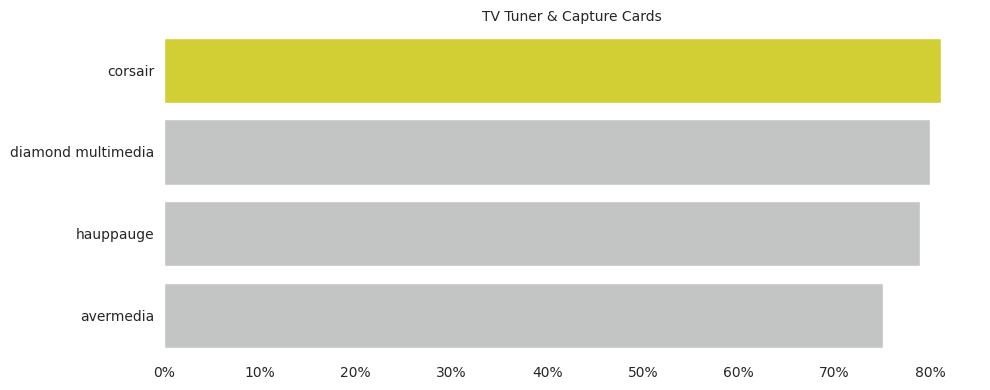

In [284]:
import numpy as np
from matplotlib.ticker import FuncFormatter

def show_values(axs, orient="v", space=.01):
    def _single(ax, color):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}%'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", color=color, fontsize=14)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax, primary_color if ax['brand'] == 'corsair' else secondary_color)
    else:
        _single(axs, 'black')



CATEGORY =  'TV Tuner & Capture Cards'
#'Fans & Cooling'
#'Memory'
#'Power Supplies'
#'TV Tuner & Capture Cards'

data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

from_year = '2018'
to_year = '2018'
if int(from_year) >= int(to_year):
    to = int(from_year)
else:
    to = int(to_year)

to = pd.Timestamp(year=to, month=12, day=31)

year_mask = (data_df["timestamp"] >= from_year) & (data_df["timestamp"] <= to)



category_df = data_df[data_df["category"] == CATEGORY]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:3] + ["corsair"]
competitors_df = data_df[data_df["brand"].isin(competitors)]


competitors_df = competitors_df[year_mask]

# global sentiment
sentiment_df = competitors_df.groupby("brand")["sentiment"].value_counts()
sentiment_df_perc = sentiment_df / sentiment_df.groupby("brand").sum()
sentiment_df_perc = (
    pd.DataFrame(sentiment_df_perc * 100)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)
sentiment_df_perc = sentiment_df_perc[sentiment_df_perc['sentiment'] == 'positive']
sentiment_df_perc = sentiment_df_perc.sort_values(by='count', ascending=False)

primary_color = "#ECE81A"
secondary_color = "#C3C5C5"
colors = []
for i, row in sentiment_df_perc.iterrows():
    if row['brand'] == 'corsair':
        colors.append(primary_color)
    else:
        colors.append(secondary_color)

fig = plt.figure(figsize=(10, 4))
plot = sns.barplot(
    sentiment_df_perc,
    x="count",
    y="brand",
    palette=colors
)
print(sentiment_df_perc)

#show_values(plot, "h", space=1)

plot.set_title(f'{CATEGORY}', fontsize=10)
plot.set_xlabel('')
plot.set_ylabel('')
plot.xaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.0f}%"))
sns.despine(bottom = True, left = True)
fig.tight_layout()
#plt.savefig(f'../output/competitors_{CATEGORY}.png')

In [271]:
# positive sentiment in time
competitors_df["period"] = competitors_df["timestamp"].copy().dt.to_period(period)
competitors_df["period"] = competitors_df["period"].dt.to_timestamp()

sentiments_count = competitors_df.groupby(["period", "brand"])["sentiment"].value_counts()
sentiments_df = pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
total_reviews = sentiments_df.groupby(["period", "brand"])["count"].sum().reset_index()

# sentiments_df = pd.merge(sentiments_df, total_reviews, on=["period", "brand"])
# sentiments_df["percentage"] = sentiments_df["count_x"] / sentiments_df["count_y"] * 100

plotly_colors = [secondary_color, "#8c8c8b", "#737372", primary_color]
fig3 = px.line(
    sentiments_df[sentiments_df['sentiment'] == 'positive'],
    x="period",
    y="count",
    height=400,
    width=1000,
    color="brand",
    markers=True,
    category_orders=dict(brand=competitors),
    color_discrete_sequence=plotly_colors,
    title="Positive Sentiment Over Time By Brand",
)
fig3.update_xaxes(showgrid=False, title_text="")
fig3.update_yaxes(showgrid=False, title_text="# Reviews")  # , ticksuffix="%")
fig3.update_layout(
    {
        "plot_bgcolor": "rgba(0, 0, 0, 0)",
        "paper_bgcolor": "rgba(0, 0, 0, 0)",
        "font_color": "#000000",
    }
)

# cambiare colori editor per salvare il grafico
fig3.write_image("../output/pos_sentiment_competitors.png")
fig3

In [168]:
from dashboard.pages.comparison.panels.topic_comparison import sentiment_aspect_df, topic_comparison

topics = list(set(sentiment_aspect_df(competitors_df)["topic"].unique()))
figures = []
for i, competitor in enumerate(competitors):
    figures.append(topic_comparison(competitors_df, competitor, plotly_colors[i], topics, 'positive'))
figures[2]

In [169]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:4] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# positive sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "positive"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig3 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig3.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig3.update_yaxes(showgrid=False, title_text="# Reviews")
fig3.update_layout({"margin": dict(l=0, r=0, b=0)})
fig3

In [170]:
data_df = pd.read_json(asum_output_dir / "reviews_sentiments.json.gz")
data_df = data_df[
    data_df["brand"].isin(list(data_df["brand"].value_counts()[:100].index))
]

category_df = data_df[data_df["category"] == "Memory"]
category_df = category_df[category_df["brand"] != "corsair"]

# competitors
competitors = list(category_df["brand"].value_counts().index)[:5] + ["corsair"]

competitors_df = data_df[data_df["brand"].isin(competitors)]

# negative sentiment in time
sentiments_count = (
    competitors_df[competitors_df["sentiment"] == "negative"]
    .groupby(["timestamp", "brand"])["sentiment"]
    .value_counts()
)
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig4 = px.line(
    sentiments_df,
    x="timestamp",
    y="count",
    color="brand",
    # title="Sentiment Over Time",
)
fig4.update_xaxes(
    showgrid=False,
    title_text="",
    # range=list(map(lambda x: datetime.datetime(x, 1, 1), years)),
)
fig4.update_yaxes(showgrid=False, title_text="# Reviews")
fig4.update_layout({"margin": dict(l=0, r=0, b=0)})
fig4

In [171]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 25, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 3, 'colname': 'S0-T...
2        [{'sentiment': 0, 'topic': 44, 'colname': 'S0-...
3        [{'sentiment': 0, 'topic': 41, 'colname': 'S0-...
4        [{'sentiment': 1, 'topic': 26, 'colname': 'S1-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 2, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 3, 'colname': 'S1-T...
28980    [{'sentiment': 0, 'topic': 8, 'colname': 'S0-T...
28981    [{'sentiment': 1, 'topic': 36, 'colname': 'S1-...
28982    [{'sentiment': 0, 'topic': 23, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [172]:
def map_topics(x):
    [y.update({"name": topic_mapping[f"T{y['topic']}"]}) for y in x]
    return x


map_topics(reviews_df["topics"][0])

[{'sentiment': 0, 'topic': 25, 'colname': 'S0-T25', 'name': 'quality'},
 {'sentiment': 0, 'topic': 39, 'colname': 'S0-T39', 'name': 'installation'}]

In [173]:
reviews_df["topics"] = reviews_df["topics"].apply(map_topics)

In [174]:
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 25, 'colname': 'S0-...
1        [{'sentiment': 0, 'topic': 3, 'colname': 'S0-T...
2        [{'sentiment': 0, 'topic': 44, 'colname': 'S0-...
3        [{'sentiment': 0, 'topic': 41, 'colname': 'S0-...
4        [{'sentiment': 1, 'topic': 26, 'colname': 'S1-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 2, 'colname': 'S0-T...
28979    [{'sentiment': 1, 'topic': 3, 'colname': 'S1-T...
28980    [{'sentiment': 0, 'topic': 8, 'colname': 'S0-T...
28981    [{'sentiment': 1, 'topic': 36, 'colname': 'S1-...
28982    [{'sentiment': 0, 'topic': 23, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

In [175]:
reviews_df.to_json(asum_output_dir / "reviews_sentiments.json.gz", orient="records")

# ASPECT BASED SENTIMENT ANALYSIS (JST)

In [176]:
NORM = "stemming"
FIELD = "text"

n_runs = 10
n_topics = 50
iterations = 1000

alpha = -1
beta = -1
gamma = -1

# Read Reviews Data

In [177]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x])
)  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(
    lambda x: [sent for sent in x if len(sent) <= 50]
)

Too Long Reviews: 0.54%
Empty Reviews: 0.05%


In [178]:
# columns name
columns_name = []

for x in range(2):
    for y in range(n_topics):
        columns_name.append("S" + str(x) + "-T" + str(y))

## PHI = vocabulary x senti aspects

In [179]:
# prepare phi file for analysis
with open(out_dir / "jst" / "final.phi") as f:
    lines = f.readlines()

    phi = {}
    tmp = ""
    for i, line in enumerate(lines):
        if i % 2 != 0:
            phi[tmp] = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
        else:
            tmp = line.strip()

phi_df = pd.DataFrame(phi)
phi_df.columns = columns_name
phi_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.013536,0.000002,0.000002,0.009105,0.007058,0.018535,0.000002,0.076919,0.015572,0.006026,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000001,0.000002,0.000002,0.000801,0.000001,0.000002,0.009759,0.139185,0.017451,0.000001,...,0.011107,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.005046,0.004171
2,0.000001,0.000002,0.000002,0.011106,0.000589,0.000002,0.019516,0.028327,0.000003,0.004645,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000001,0.000002,0.040987,0.000001,0.000001,0.042543,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.018339,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
4,0.000001,0.000002,0.000002,0.008005,0.005882,0.000002,0.000190,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.003650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20357,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20358,0.000001,0.000002,0.000002,0.000001,0.000001,0.000213,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20359,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001
20360,0.000001,0.000002,0.000002,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000001,...,0.000001,0.000001,8.279955e-07,0.000003,0.000001,0.000002,0.000001,0.000002,0.000002,0.000001


## PI = documents x sentiment

In [180]:
# prepare pi file for analysis
pi_df = pd.read_csv(out_dir / "jst" / "final.pi", sep=" ", header=None)
pi_df.drop([0, 1, 4], axis=1, inplace=True)
pi_df.columns = ["S0", "S1"]
pi_df

,S0,S1
0,0.745614,0.254386
1,0.028090,0.971910
2,0.061905,0.938095
3,0.119048,0.880952
4,0.722222,0.277778
...,...,...
28978,0.932432,0.067568
28979,0.417808,0.582192
28980,0.722222,0.277778
28981,0.722222,0.277778


## THETA = documents x senti aspects

In [181]:
with open(out_dir / "jst" / "final.theta") as f:
    lines = f.readlines()

    theta = []
    tmp = []
    for i, line in enumerate(lines):
        if i % 3 != 0:
            values = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
            tmp.extend(values)
        else:
            if tmp:
                theta.append(tmp)
                tmp = []

theta_df = pd.DataFrame(theta, columns=columns_name)
theta_df

,S0-T0,S0-T1,S0-T2,S0-T3,S0-T4,S0-T5,S0-T6,S0-T7,S0-T8,S0-T9,...,S1-T40,S1-T41,S1-T42,S1-T43,S1-T44,S1-T45,S1-T46,S1-T47,S1-T48,S1-T49
0,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176,0.377647,0.001176,0.001176,...,0.003448,0.003448,0.003448,0.003448,0.279310,0.003448,0.003448,0.003448,0.003448,0.003448
1,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578,0.000578
2,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.000508,0.000508,0.000508,0.000508,0.000508,0.447208,0.000508,0.244162,0.000508,0.000508
3,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
4,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28977,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.000990,0.080198,...,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703,0.002703
28978,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,0.001449,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000
28979,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.001639,0.526230,0.001639,0.001639,...,0.001176,0.001176,0.001176,0.095294,0.001176,0.001176,0.001176,0.001176,0.001176,0.001176
28980,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,0.007692,...,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000


In [182]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  31


In [183]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0        [S0-T7, S0-T42, S1-T5, S1-T44]
1                      [S1-T28, S1-T39]
2              [S0-T19, S1-T45, S1-T47]
3                       [S1-T7, S1-T29]
4                              [S0-T39]
                      ...              
28977          [S0-T30, S0-T41, S1-T11]
28978                  [S0-T24, S0-T38]
28979    [S0-T7, S0-T18, S1-T8, S1-T12]
28980                          [S0-T42]
28981                           [S0-T6]
Length: 28982, dtype: object

In [184]:
(f_theta_df > T).sum(axis=1).describe()

count    28951.000000
mean         3.031018
std          1.424995
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          8.000000
dtype: float64

In [185]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
1        [{'sentiment': 1, 'topic': 28, 'colname': 'S1-...
2        [{'sentiment': 0, 'topic': 19, 'colname': 'S0-...
3        [{'sentiment': 1, 'topic': 7, 'colname': 'S1-T...
4        [{'sentiment': 0, 'topic': 39, 'colname': 'S0-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 24, 'colname': 'S0-...
28979    [{'sentiment': 0, 'topic': 7, 'colname': 'S0-T...
28980    [{'sentiment': 0, 'topic': 42, 'colname': 'S0-...
28981    [{'sentiment': 0, 'topic': 6, 'colname': 'S0-T...
28982                                                  NaN
Name: topics, Length: 28983, dtype: object

In [186]:
for x in reviews_df["topics"]:
    if type(x) is float:
        print(x)

nan


## Sentiment

In [187]:
doc_sentiment = pi_df.idxmax(axis=1).map(
    lambda x: "positive" if x == "S0" else "negative"
)
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

# Sentiment Over Time

In [188]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count).rename(columns={"sentiment": "count"}).reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics

In [189]:
count = Counter()
for x in reviews_df["topics"].values:
    if type(x) is float:
        print(x)
        continue
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
# topics_count["topic"] = topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")
topics_count = pd.DataFrame(topics_count.groupby("topic")["count"].sum()).reset_index()

order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=["#108de4"],
    category_orders=dict(topic=order),
    height=1000,
    width=1200,
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})
fig1

nan


In [190]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    if type(t) is float:
        print(t)
        continue

    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

# pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby("topic")["pos"].sum()).reset_index()

# neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby("topic")["neg"].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

nan
